In [1]:
import os
import os.path as op
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne.datasets import fetch_fsaverage
from mne.minimum_norm import make_inverse_operator


def create_fsaverage_forward(epochs, **kwargs):
    """
    A forward model is an estimation of the potential or field distribution for a known source
    and for a known model of the head. Returns EEG forward operator with a downloaded template
    MRI (fsaverage).

    Parameters
    ----------
    epochs : mne.epochs.Epochs
            MNE epochs object containing portions of raw EEG data built around specified timestamp(s)

    kwargs: arguments
            Specify any of the following arguments for the mne.make_forward_solution() function. These include midist=5.0, n_jobs=1.

    Returns
    -------
    fwd: mne.forward.forward.Forward
    Forward operator built from the user_input epochs and the fsaverage brain.
    """
    
    defaultKwargs = { 'n_jobs': 1, 'mindist': 5.0 }
    kwargs = { **defaultKwargs, **kwargs }

    # Download fsaverage files
    fs_dir = fetch_fsaverage(verbose=True)
    subjects_dir = op.dirname(fs_dir)

    # Used to download/load example MRI brain model
    # The files live in:
    subject = 'fsaverage'
    trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
    src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
    bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')
    


    fwd = mne.make_forward_solution(epochs.info,
                                    trans=trans,
                                    src=src,
                                    bem=bem,
                                    eeg=True,
                                    **kwargs)

    return fwd


def create_inverse_solution(
        epochs,
        forward,
        epoch_num=0,
        covariance_method=[
            'empirical',
            'shrunk'],
        apply_inverse_method="dSPM",
        loose=0.2,
        depth=0.8,
        snr=3.0,
        pick_ori='normal'):
    """
    Calculates the inverse solution, which is an Estimation of the unknown sources
    corresponding to the measured EEG or MEG.

    Parameters
    ----------
    epochs : mne.epochs.Epochs or mne.evoked.EvokedArray
            MNE epochs or evoked object containing portions of raw EEG data built around specified
            timestamp(s). The inverse solution will be built based on the data in the specified epoch.

    forward: mne.forward.forward.Forward
        Specifies the 'forward' parameter in the mne.minimum_norm.make_inverse_operator() function.

    epoch_num: int or str
        If input is an 'int' then this specifies which epoch in the 'epochs' number to build an
        inverse solution from. If input is "all" then an inverse solution will be built from all
        epochs.

    covariance_method: list
        Specifies the 'method' parameter in the mne.compute_covariance() function.

    loose: float
        Specifies the 'loose' parameter in the mne.minimum_norm.make_inverse_operator() function

    depth: float
        Specifies the 'depth' parameter in the mne.minimum_norm.make_inverse_operator() function

    snr: float
        Used to calculate 'lambda2' in the equation 'lambda2 = 1.0 / snr ** 2'

    inverse_epochs_method: str
        Specifies the 'method' parameter in mne.minimum_norm.apply_inverse_epochs() (if using epochs)
        or mne.minimum_norm.apply_inverse() (if using evoked data).

    pick_ori: str
        Specifies the 'pick_ori' parameter in mne.minimum_norm.apply_inverse_epochs() (if using epochs)
        or mne.minimum_norm.apply_inverse() (if using evoked data).

    Returns
    -------
    stc: mne.source_estimate.SourceEstimate
            Forward operator built from the user_input epochs and the fsaverage brain.
    """
    noise_cov = mne.compute_covariance(epochs, method=covariance_method)

    inverse_operator = make_inverse_operator(epochs.info, forward, noise_cov,
                                             loose=loose, depth=depth)

    lambda2 = 1.0 / snr ** 2

    if isinstance(epoch_num, int):
        epochs = epochs[epoch_num]

    # If epoch_num is any string other than "all" return false

    if isinstance(epochs, mne.epochs.Epochs):
        from mne.minimum_norm import apply_inverse_epochs
        stc = apply_inverse_epochs(epochs,
                                   inverse_operator=inverse_operator,
                                   lambda2=lambda2,
                                   method=apply_inverse_method,
                                   pick_ori=pick_ori)
        stc = stc[0]

    elif isinstance(epochs, mne.evoked.EvokedArray):
        from mne.minimum_norm import apply_inverse
        stc = apply_inverse(epochs,
                            inverse_operator=inverse_operator,
                            lambda2=lambda2,
                            method=apply_inverse_method,
                            pick_ori=pick_ori)

    return stc


def plot_topomap_3d_brain(
        epochs,
        stc='auto',
        display_time=0,
        backend='auto',
        views=[
            'lat',
            'fro',
            'dor'],
        view_layout='horizontal',
        size=300,
        hemi='both',
        colormap='mne',
        colormap_limit_type='lims',
        cmin=None,
        cmid=None,
        cmax=None,
        colorbar=True,
        time_viewer = 'auto',
        background='black',
        foreground='white',
        spacing='oct6',
        smoothing_steps=3,
        figure=None,
        **kwargs):
    """
    Creates a still image of the epochs or stc data mapped to the brain using the mne.SourceEstimate.plot
    function. Written to work with either a 'pyvista' or 'matplotlib' backend. Pyvista will be faster but
    at the expense of the returned object being less compatible with other functions. The 'matplotlib' backend
    will return a matplotlib figure which is widely used in python.

    Parameters
    ----------
    epochs : mne.epochs.Epochs or mne.evoked.EvokedArray
            MNE epochs or evoked object containing portions of raw EEG data built around specified
            timestamp(s) The inverse solution will be built based on the data in the specified epoch.

    stc: mne.source_estimate.SourceEstimate or 'auto'
            'inverse_solution' to generate the plot from. If set to "auto" (default) then an stc will be
            automatically generated however, this will significantly increase running time.

    display_time: float or None
            Specifies the 'initial_time' parameter in the mne.SourceEstimate.plot() function to show
            a plot at a specific time. Defaults to 0.

    backend: ‘auto’ or ‘mayavi’ or ‘pyvista’ or ‘matplotlib’
            Specifies the 'initial_time' parameter in the mne.SourceEstimate.plot() function. "Which backend
            to use. If 'auto' (default), tries to plot with pyvista, but resorts to matplotlib if no 3d
            backend is available." Note that mayavi has not been tested for this function. Using matplotlib
            as a backend will lead to some functionality breaking (look at the documentation on a function-by-function
            basis to know how) but it is the most widely compatable backend. Multiplotting and multi-views for the matplotlib backend
            was built by hand for this function.

    views: str or list
            Specifies the 'view' parameter in the mne.SourceEstimate.plot() function. For any backend
            can be any combination of 'lat' (lateral), 'med' (medial), 'ros' (rostral), 'cau' (caudal),
            'dor' (dorsal), 'ven'(ventral), 'fro'(frontal), 'par' (parietal). The following arguments
            are also accepted but are NOT compatible with the matplotlib backend 'axi' (axial), 'sag'
            (sagittal), and 'cor'(coronal). Defaults to ['lat', 'fro', 'dor'].

    view_layout: str
            Specifies the 'view_layout' parameter in the mne.SourceEstimate.plot() function. Should be
            'vertical' or 'horizontal'. Using 'horizontal' with hemi set to 'split' might cause issues.
            NOTE that this argument has no effect when using the 'matplotlib' backend. Defaults to 'horizontal'

    size: int
            If using a non-matplotlib backend then specifies how many pixels tall EACH "view" of the brian will be.
            If using matplotlib as a backend then the height will be divided by 100 and rounded the closest inch.
            For example, entering 100 will result in 1 inch per view. If plotting multiple views overall size of
            the multiplot is automatically calculated to fit all views. Defaults to 300.              

    hemi: 'lh’ or ‘rh’ or ‘both’ or ‘split’
            Specifies the 'initial_time' parameter in the mne.SourceEstimate.plot() function. Can be
            one of ‘lh’, ‘rh’, ‘both’, or ‘split’. Defaults to 'both'. Note that when using the matplotlib
            backend that 'split' and 'both' will return a 'split' view since both is not avalible.
            Defaults to 'both'

    colormap: str or np.ndarray of float, shape(n_colors, 3 | 4)
            Specifies the 'colormap' parameter in the mne.SourceEstimate.plot() function. Can use a
            matplotlib colormap by name or take a custom look up table as input. Defaults to "mne"

    colormap_limit_type: str
            Can be either "lims" or "pos_lims". "lims" means that your cmin, cmid, and cmax values will specify the
            "Lower, middle, and upper bounds for colormap". Using "pos_lims" will lead to cmin, cmid, and cmax representing
            the "Lower, middle, and upper bound for colormap. Positive values will be mirrored directly across
            zero during colormap construction to obtain negative control points." Defaults to "lims"

    cmin: float
            Specifies the lower value of the colormap limit. If no value is specified then
            limits will be automatically calculated based on the mne.SourceEstimate.plot() function defaults OR
            will be the negative value of cmax if only that is provided.

    cmid: float
            Specifies the middle value of the colormap limit. If no value is specified then
            limits will be automatically calculated based on the mne.SourceEstimate.plot() function defaults OR
            will be the value between cmin and cmax if one/both of them is provided.

    cmax: float
            Specifies the middle value of the colormap limit. If no value is specified then
            limits will be automatically calculated based on the mne.SourceEstimate.plot() function defaults OR
            will be the negative value of cmin if only that is provided.

    colorbar: bool
            Determines whether to include a colorbar on the plot not. Defaults to True.

    time_viewer: bool or str
            Specifies the 'time_viewer' parameter in the mne.SourceEstimate.plot() function. 'auto' by default. With a
            PyVista backend this will allow for the user to interact with the genreated plot. Has no effect on figures
            generated with the matplotlib backend. 

    background: matplotlib color
            Specifies the 'background' parameter in the mne.SourceEstimate.plot() function. Does not work with plots
            made with the matplotlib backend. 'black' by default.

    foreground: matplotlib color
            Specifies the 'foreground' parameter in the mne.SourceEstimate.plot() function. Does not work with plots
            made with the matplotlib backend. 'white' by default.

    spacing: str
            Specifies the 'spacing' parameter in the mne.SourceEstimate.plot() function. "The spacing to use for the
            source space. Can be 'ico#' for a recursively subdivided icosahedron, 'oct#' for a recursively subdivided
            octahedron, or 'all' for all points. In general, you can speed up the plotting by selecting a sparser source
            space. Has no effect with mayavi backend. Defaults to ‘oct6’".

    smoothing_steps: int
            Specifies the 'smoothing_steps' parameter in the mne.SourceEstimate.plot() function. "The amount of smoothing".
            3 by default.

    figure: instance of mayavi.core.api.Scene or instance of matplotlib.figure.Figure or list or int or None
            Specifies the 'figure' parameter in the mne.SourceEstimate.plot() function. "If None, a new figure
            will be created. If multiple views or a split view is requested, this must be a list of the appropriate
            length. If int is provided it will be used to identify the Mayavi figure by it’s id or create a new figure
            with the given id. If an instance of matplotlib figure, mpl backend is used for plotting." NOTE that if plotting
            multiple views OR a split/both hemi with the matplotlib backend then this argument will not work. None by default.

    Returns
    -------
    brain: mne.viz._brain._brain.Brain OR matplotlib.figure.Figure
            If using 'pyvista' then returns a mne.viz figure of brain with input epoch or stc data mapped to it. If
            using 'matplotlib' backend then returns a matplotlib.figure.Figure.
    """
    
    defaultKwargs = { 'transparent': False, 'alpha': 1.0, 'surface': 'inflated', 'cortex': 'classic',
                     'subject': None, 'time_label': 'auto', 'time_unit': 's', 'volume_options': None,
                     'subjects_dir': None, 'title': None, 'show_traces': 'auto', 'src': None, 'verbose': None }
    kwargs = { **defaultKwargs, **kwargs }    
    

    # if hemi == "split" and view_layout == 'horizontal':
    #     # Return warning that the horizontal with split isn't reccomended

    # Calculate stc if one is not provided
    if stc == 'auto':
        forward = create_fsaverage_forward(epochs)
        stc = create_inverse_solution(epochs, forward)

    # Prep properties of the figure if not using a matplotlib backend
    if backend != 'matplotlib':
        # Calculate font size for colorbar/time label
        colorbar_font_size = round(size / 25)
        time_label_size = round(size / 33)

        # add 4/3 of the height in width for each visual
        if view_layout == "horizontal":
            auto_plot_size = [
                round(len(views) * (size * 4 / 3)), size]
        elif view_layout == "vertical":
            auto_plot_size = [
                round(
                    size *
                    4 /
                    3),
                size *
                len(views)]

    else:
        colorbar_font_size = None
        time_label_size = None
        img_figsize = round(size / 100)
        if isinstance(views, str):
            views = [views]
        
        # Size input for plotting function does nothing with matplotlib backend
        auto_plot_size = None
        
        # Layout MUST be horizontal and foreground/background colors cannot be changed
        view_layout == "horizontal"
        background='black'
        foreground = 'white'

        import matplotlib.gridspec as gridspec

        def move_axes(ax, fig):
            # get a reference to the old figure context so we can release it
            old_fig = ax.figure

            # remove the Axes from it's original Figure context
            ax.remove()
            ax.figure = fig

            # add the Axes to the registry of axes for the figure
            fig.axes.append(ax)
            fig.add_axes(ax)

    # Set colorbar values
    if (cmin is None) and (cmax is None):
        clim_values = 'auto'
    else:
        if (cmin is None):
            cmin = -cmax
        if (cmax is None):
            cmax = -cmin
        if cmid is None:
            cmid = (cmin + cmax) / 2

        if colormap_limit_type == 'lims':
            clim_values = dict(kind='value', lims=[
                cmin,
                cmid,
                cmax]
            )
        elif colormap_limit_type == 'pos_lims':
            clim_values = dict(kind='value', pos_lims=[
                cmin,
                cmid,
                cmax]
            )

    def make_plot(
        views=views,
        hemi=hemi,
        size=auto_plot_size,
        colorbar = colorbar,
        figure=figure
    ):
        plt.show(block=True)
        brain = stc.plot(
            views=views,
            hemi=hemi,
            colormap=colormap,
            size=size,
            initial_time=display_time,
            clim=clim_values,
            colorbar=colorbar,
            figure=figure,
            background=background,
            foreground=foreground,
            backend=backend,
            view_layout=view_layout,
            spacing = spacing,
            smoothing_steps=smoothing_steps,
            brain_kwargs=dict(
                show=False),
            add_data_kwargs=dict(
                time_label_size=time_label_size,
                colorbar_kwargs=dict(
                    label_font_size=colorbar_font_size)),
            **kwargs
        )
        return brain
    
    
    if backend != 'matplotlib':
        return (make_plot())

    elif (hemi == 'lh' and len(views) == 1) or (hemi == 'rh' and len(views) == 1):
        return (make_plot(views=views[0]))

    else:

        from matplotlib.transforms import Bbox

        if hemi == 'both' or hemi == 'split':
            brain_hemi = ['lh', 'rh']

        else:
            brain_hemi = [hemi]

        img_width = len(views)
        img_height = len(brain_hemi)

        base_fig, ax = plt.subplots(
            figsize=(img_width * img_figsize, img_width * img_figsize), facecolor="black")
        plt.axis('off')

        add_colorbar = False

        # Set flag to generate colorbar later since adding it early causes bad
        # scaling
        if colorbar:
            colorbar = False
            add_colorbar = True

        x_pos = 0
        axes_pos = 1

        # Run to add new fig for each view
        for v in range(len(views)):

            y_pos = 0

            # run twice for each side of the brain if using both or split
            for h in range(len(brain_hemi)):

                plt.show(block=True)
                fig = plt.figure(figsize=(img_figsize, img_figsize))
                make_plot(
                    figure=fig,
                    hemi=brain_hemi[h],
                    views=str(
                        views[v]),
                    colorbar=colorbar)

                # Copy over the brain image only
                move_axes(fig.axes[0], base_fig)

                # Reposition copied over figure
                pos1 = base_fig.axes[1].get_position()
                pos2 = [
                    pos1.x0 + x_pos,
                    pos1.y0 + y_pos,
                    pos1.width,
                    pos1.height]
                base_fig.axes[axes_pos].set_position(pos2)  # 1, 3, 4, 5

                # Increment axes and positioning indexes
                axes_pos += 1
                y_pos = 1

            x_pos += 1

        # Generate dummy colorbar to move to the main figure
        if add_colorbar:
            #cbar_size = base_fig.get_size_inches()[0]/2

            cbar_width = img_width * img_figsize * 0.65

            if img_height == 2:
                cbar_height = img_height * img_figsize * 0.65
            else:
                cbar_height = img_height * 2 * img_figsize * 0.65

            if img_width >= 3:
                cbar_height = cbar_height * (img_width * 0.5)
                cbar_width = img_width * img_figsize * 0.85

            elif img_width >= 5:
                cbar_height = cbar_height * (img_width * 0.30)
                cbar_width = img_width * img_figsize * 0.4

            fig = plt.figure(figsize=(img_width * img_figsize * 0.65, cbar_height))
            make_plot(figure=fig, hemi='lh', views='fro', colorbar=True)
            move_axes(fig.axes[1], base_fig)

            pos2 = [pos1.x0 + 0, pos1.y0 + 1, pos1.width, pos1.height]

            base_fig.axes[axes_pos].set_position(pos2)

        base_fig.subplots_adjust(top=0.1, bottom=0, right=0.1, left=0,
                                 hspace=0, wspace=0)

    #plt.close(base_fig)
    return(base_fig)


def save_animated_topomap_3d_brain(
        brain,
        filename,
        time_dilation=20,
        interpolation='linear',
        framerate=12,
        time_viewer=True):
    """
    Saves an animated mne.viz._brain._brain.Brain object as a gif using the mne.viz.Brain.save_movie()
    function. Saves animation of the entire figure.

    Parameters
    ----------
    brain : brain: mne.viz._brain._brain.Brain
                mne.viz figure of brain which will be saved as a gif

    filename: str
                'filename' parameter in mne.viz.Brain.save_movie() function. "Path at which to save the movie.
                The extension determines the format (e.g., '*.mov', '*.gif', …; see the imageio documentation
                for available formats)".

    time_dilation: float
            'time_dilation' parameter in mne.viz.Brain.save_movie() function. "Factor by which to stretch time
            (default 4). For example, an epoch from -100 to 600 ms lasts 700 ms. With time_dilation=4 this
            would result in a 2.8 s long movie."

    interpolation: str or None
            'interpolation' parameter in mne.viz.Brain.save_movie() function. "Interpolation method
            (scipy.interpolate.interp1d parameter). Must be one of ‘linear’, ‘nearest’, ‘zero’, ‘slinear’,
            ‘quadratic’, or ‘cubic’."

    time_viewer: bool
                'time_dilation' parameter in mne.viz.Brain.save_movie() function. "If True, include time viewer
                traces".

    Returns
    -------
    """

    brain.save_movie(filename,
                     time_dilation=time_dilation,
                     tmin=brain.data['time'][0],
                     tmax=brain.data['time'][-1],
                     framerate=framerate,
                     interpolation=interpolation,
                     time_viewer=time_viewer)


def animate_matplot_brain(
    epochs,
    stc='auto',
    views=[
        'lat',
        'dor',
        'fro'],
    size=200,
    hemi='both',
    colormap='mne',
    colorbar = True,
    colormap_limit_type='lims',
    cmin=None,
    cmid=None,
    cmax=None,
    spacing='oct5',
    smoothing_steps=2,
    steps=3,
    frame_rate=12,
    **kwargs):
    
    defaultKwargs = { 'transparent': False, 'alpha': 1.0, 'surface': 'inflated', 'cortex': 'classic',
                 'subject': None, 'time_label': None, 'time_unit': 's', 'volume_options': None,
                 'subjects_dir': None, 'title': None, 'show_traces': 'auto', 'src': None, 'verbose': None }
    kwargs = { **defaultKwargs, **kwargs }
    
    import matplotlib.animation as animation

    if isinstance(views, str):
        views = [views]

    frames_to_show = round(user_epoch.times.shape[0] / steps)
    times_to_show = np.linspace(
        user_epoch.tmin,
        user_epoch.tmax,
        frames_to_show)
    
    # FOR TESTING ONLY DELETE LATER
    times_to_show = times_to_show[0:2]  # FOR TESTING ONLY DELETE LATER

    ms_between_frames = 1000 / frame_rate

    fig, ax = plt.subplots()

    def plotting(figure=None, display_time=0, cbar = False, hemi = hemi, views = views):
        return (plot_topomap_3d_brain(epochs,
                                      stc=stc,
                                      backend='matplotlib',
                                      hemi=hemi,
                                      views=views,
                                      colormap=colormap,
                                      colorbar = cbar,
                                      background='black',
                                      foreground = 'white',
                                      spacing=spacing,
                                      smoothing_steps=smoothing_steps,
                                      colormap_limit_type='lims',
                                      cmin=cmin,
                                      cmid=cmid,
                                      cmax=cmax,
                                      size=size,
                                      display_time=display_time,
                                      figure=figure,
                                      time_viewer = False,
                                      **kwargs
                                      )
                )

    if (hemi == 'lh' and len(views) == 1) or (
            hemi == 'rh' and len(views) == 1):
        # Plotting for single view/hemi matplotlib.figure.Figure
        def animate(frame):

            fig.clear()
            # get new image from list
            plotting(figure=fig,
                     display_time=frame,
                     cbar = colorbar
                     )

            return[fig]

        ani = animation.FuncAnimation(
            fig,
            animate,
            frames=times_to_show,
            interval=ms_between_frames,  # Time between frames in ms
            blit=False
        )

    else:
        # Plotting for multi view/hemi matplotlib.image.AxesImage
#         fig = plt.figure()
#         ax = plt.gca()

        fig, ax = plt.subplots()
        
        if colorbar:
            add_colorbar = 1
            colorbar = False
        else:
            add_colorbar = 0

        if views == 'lh' or views == 'rh':
            img_height = 1
        else:
            img_height = 2
            
        img_width = len(views)
        img_figsize = round(size / 100)
        
        # Generate dummy colorbar to move to the main figure
        if add_colorbar:
            #cbar_size = base_fig.get_size_inches()[0]/2

            cbar_width = img_width * img_figsize * 0.65

            if img_height == 2:
                cbar_height = img_height * img_figsize * 0.65
            else:
                cbar_height = img_height * 2 * img_figsize * 0.65

            if img_width >= 3:
                cbar_height = cbar_height * (img_width * 0.5)
                cbar_width = img_width * img_figsize * 0.85

            elif img_width >= 5:
                cbar_height = cbar_height * (img_width * 0.30)
                cbar_width = img_width * img_figsize * 0.4
                
            def copy_axes(ax, fig):
                old_fig = ax.figure
                ax.figure = fig
                fig.axes.append(ax)
                fig.add_axes(ax)
            

            cbar_fig = plt.figure(figsize=(img_width * img_figsize * 0.65, cbar_height))
            plotting(figure=cbar_fig, hemi='lh', views='fro', cbar=True)

        def animate(frame):
            # remove previous image
            ax.clear()

            plt.show(block=True)

            brain = plotting( 
                display_time=frame,
                cbar = False
            )
            
            if add_colorbar:
                copy_axes(cbar_fig.axes[1], brain)

            # Convert plot to image/frame
            brain.canvas.draw()
            plot_image = np.frombuffer(
                brain.canvas.tostring_rgb(), dtype=np.uint8)
            plot_image = plot_image.reshape(
                brain.canvas.get_width_height()[::-1] + (3,))

            if (img_width > 2):
                cropped_height = round(
                    plot_image.shape[0] * (img_height / img_width) + plot_image.shape[0] * 0.07)
                cropped_height = plot_image.shape[1] - cropped_height
                plot_image = plot_image[cropped_height:, :, :]

            # display new image
            ax.imshow(plot_image)

        ani = animation.FuncAnimation(
            fig,
            animate,
            frames=times_to_show,
            interval=ms_between_frames,  # Time between frames in ms
            blit=False
        )

    return ani

## Prep environment

In [2]:
# Specify electrode layout
electrode_layout = 'standard_1020' # toggle to switch to 'standard_1005' if needed, default to 'standard_1020'.

# Calculate starting/ending frames
start_hour = 0
start_minute = 2
start_second = 34
start_ms = 0

end_hour = 0
end_minute = 2
end_second = 34
end_ms = 200

In [3]:
raw = mne.io.read_raw_eeglab('../data/1122/fixica.set')
raw = raw.set_eeg_reference(projection=True)
montage = mne.channels.make_standard_montage(electrode_layout)

Reading /Users/mpin/Documents/MDS/capstone/simpl_eeg_capstone/data/1122/fixica.fdt


<ipython-input-3-b0254cc0d099>:1: RuntimeWarning: Data file name in EEG.data (1122 fix ica.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).
  raw = mne.io.read_raw_eeglab('../data/1122/fixica.set')


Adding average EEG reference projection.
1 projection items deactivated


In [4]:
sampling_freq_hz = raw.info.get('sfreq') 

start_frame = round((sampling_freq_hz/1000) * start_ms) \
    + (start_second * sampling_freq_hz) \
    + (start_minute * (sampling_freq_hz * 60)) \
    + (start_hour * (sampling_freq_hz * 3600))

end_frame = round((sampling_freq_hz/1000) * end_ms) \
    + (end_second * sampling_freq_hz) \
    + (end_minute * (sampling_freq_hz * 60)) \
    + (end_hour * (sampling_freq_hz * 3600))

duration = (end_frame - start_frame) / sampling_freq_hz # duration of specified window in seconds

print("start frame is", start_frame, "at", str(start_hour) + ":" + str(start_minute) + ":" + str(start_second) + "." + str(start_ms))
print("end frame is", end_frame, "at", str(end_hour) + ":" + str(end_minute) + ":" + str(end_second) + "." + str(end_ms))
print("duration is", duration, "seconds")

start frame is 315392.0 at 0:2:34.0
end frame is 315802.0 at 0:2:34.200
duration is 0.2001953125 seconds


In [5]:
# Set up events and use it to generate mock epoch and evoked data

user_event_frame = round((start_frame + end_frame)/2) # Pick frame in the middle of the two specified frames to build epoch around
user_event = ([[int(user_event_frame), 0, 1]]) # Format event to make mock epoch
user_event = np.array(user_event)

min_time = 0 - duration/2 # time to start from before epoch, should line up with user specified start time
max_time = 0 + duration/2 # time to stop from after epoch time, should line up with user specified end time

In [6]:
event_dict = {'user_specified_time': 1} # Create single mock event, needed to make epoch 

user_epoch = mne.Epochs(raw,
                        user_event,
                        tmin = min_time,
                        tmax = max_time,
                        event_id = event_dict,
                        preload=True)

user_evoked = user_epoch['user_specified_time'].average()

Not setting metadata
Not setting metadata
1 matching events found
Setting baseline interval to [-0.10009765625, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 1 events and 411 original time points ...
0 bad epochs dropped


## Test functions

### Build forward and reverse
--------

In [24]:
%%time
fwd = create_fsaverage_forward(user_epoch)

0 files missing from root.txt in /Users/mpin/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage
Source space          : /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /Users/mpin/opt/miniconda3/lib/python3.8/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000 

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   21.1s remaining:   35.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   21.1s remaining:   12.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   21.2s finished


    Skipping interior check for 2241 sources that fit inside a sphere of radius   47.7 mm
    Skipping solid angle check for 0 points using Qhull


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.



Setting up for EEG...


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.9s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.9s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.0s finished


Computing EEG at 20484 source locations (free orientations)...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.6s remaining:    4.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.7s remaining:    1.6s



Finished.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.8s finished


CPU times: user 1.79 s, sys: 1.32 s, total: 3.11 s
Wall time: 27.2 s


In [8]:
%%time
stc = create_inverse_solution(user_epoch, fwd)

Computing rank from data with rank=None
    Using tolerance 9.7e-13 (2.2e-16 eps * 19 dim * 2.3e+02  max singular value)
    Estimated rank (eeg): 18
    EEG: rank 18 computed from 19 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 19 -> 18
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using SHRUNK
Done.
Using cross-validation to select the best estimator.
Number of samples used : 411
log-likelihood on unseen data (descending order):
   shrunk: -13.314
   empirical: -109.930
selecting best estimator: shrunk
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 19 channels.
    19 out of 19 channels remain after picking
Se

### Test all individual plotting options
--------

In [19]:
%%time
test_fig = plot_topomap_3d_brain(user_epoch, stc = stc)

Using control points [0.50536209 0.58409179 1.15099003]
CPU times: user 6.39 s, sys: 1.61 s, total: 7.99 s
Wall time: 3.06 s


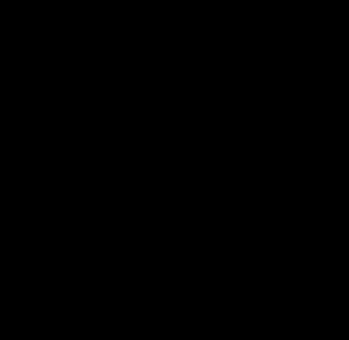

<Figure size 144x144 with 0 Axes>

Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 144x144 with 0 Axes>

Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 144x144 with 0 Axes>

Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 144x144 with 0 Axes>

Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 144x144 with 0 Axes>

Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 144x144 with 0 Axes>

Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 280.8x280.8 with 0 Axes>

Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


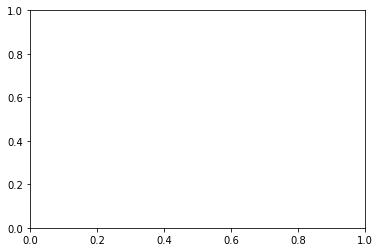

<class 'matplotlib.figure.Figure'>
CPU times: user 6.58 s, sys: 1.27 s, total: 7.85 s
Wall time: 5.17 s


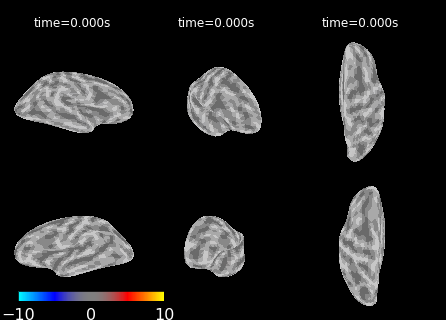

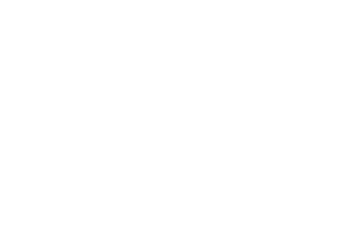

In [10]:
%%time
test_multi_matplotlib = plot_topomap_3d_brain(user_epoch,
                                         stc = stc,
                                         backend = 'matplotlib',
                                         hemi = 'both',
                                         cmax=10,
                                         smoothing_steps = 2,
                                         size = 200,
                                         spacing = 'oct5'
                                         );

print(type(test_multi_matplotlib))
plt.axis('off')
test_multi_matplotlib

<class 'numpy.ndarray'>


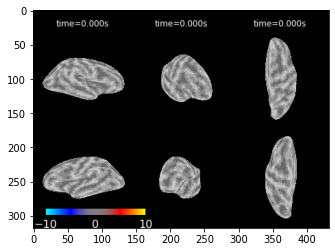

In [11]:
fig, ax = plt.subplots()

img_width = 3
img_height = 2

# Convert plot to image/frame
test_multi_matplotlib.canvas.draw()
plot_image = np.frombuffer(
    test_multi_matplotlib.canvas.tostring_rgb(), dtype=np.uint8)
plot_image = plot_image.reshape(
    test_multi_matplotlib.canvas.get_width_height()[::-1] + (3,))

if (img_width > 2):
    cropped_height = round(
        plot_image.shape[0] * (img_height / img_width) + plot_image.shape[0] * 0.07)
    cropped_height = plot_image.shape[1] - cropped_height
    plot_image = plot_image[cropped_height:, :, :]

print(type(plot_image))
# plt.imshow(plot_image)
# display new image
ax.imshow(plot_image)

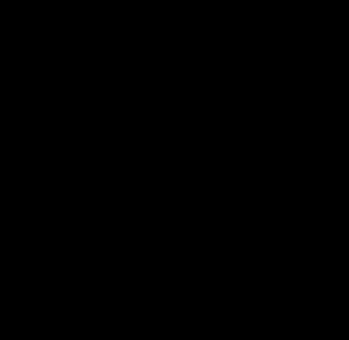

<Figure size 144x144 with 0 Axes>

Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 144x144 with 0 Axes>

Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 144x144 with 0 Axes>

Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 280.8x280.8 with 0 Axes>

Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


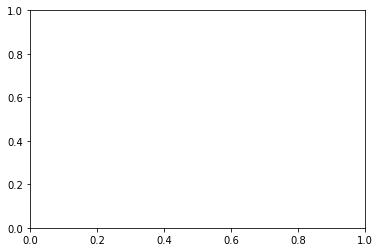

<class 'matplotlib.figure.Figure'>
CPU times: user 9.61 s, sys: 2.05 s, total: 11.7 s
Wall time: 4.96 s


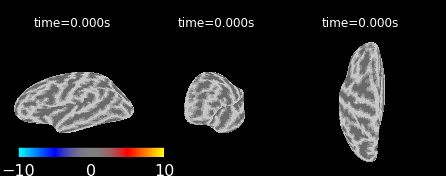

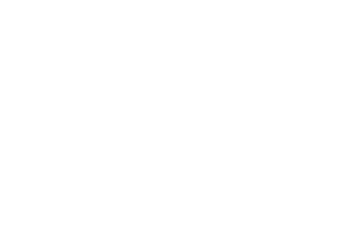

In [12]:
%%time
test_single_multi_matplotlib = plot_topomap_3d_brain(user_epoch,
                                         stc = stc,
                                         backend = 'matplotlib',
                                         hemi = 'lh',
                                         cmax=10,
                                         smoothing_steps = 2,
                                         size = 200
                                         );

print(type(test_single_multi_matplotlib))
plt.axis('off')
test_single_multi_matplotlib

Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    3 smooth iterations done.


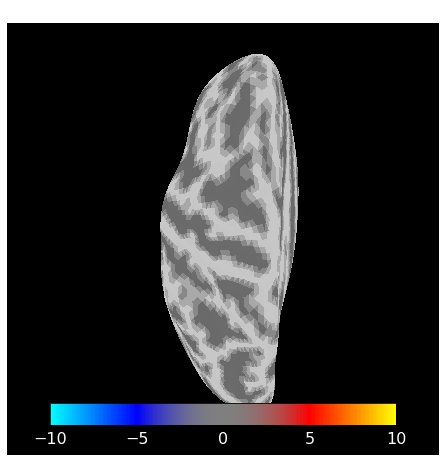

<class 'matplotlib.figure.Figure'>


In [13]:
test_single_fig_matplot = plot_topomap_3d_brain(user_epoch,
                                         stc = stc,
                                         backend = 'matplotlib',
                                         hemi = 'lh',
                                         views = 'dor',
                                         cmax=10,
                                         );

#plt.axis('off')
print(type(test_single_fig_matplot))

In [20]:
%%time
save_animated_topomap_3d_brain(test_fig, filename = "test_brain2.gif")

CPU times: user 1min 52s, sys: 5.57 s, total: 1min 57s
Wall time: 2min 4s


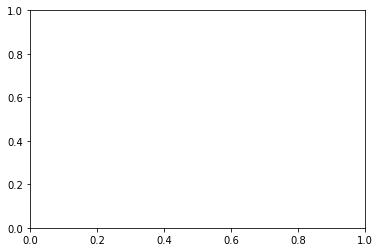

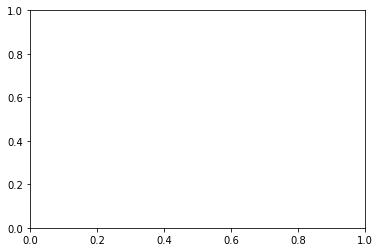

<Figure size 187.2x187.2 with 0 Axes>

Using control points [0.50536209 0.58409179 1.15099003]
Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


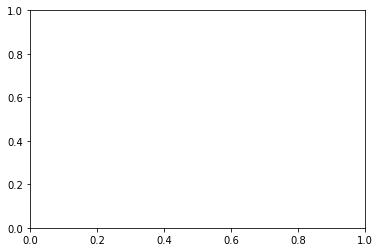

matplotlib.animation.FuncAnimation

In [15]:
test_matplot_animate_multi = animate_matplot_brain(
    user_epoch,
    stc = stc,
    hemi = 'both',
    views = ['lat', 'cau'],
    size = 200
);

type(test_matplot_animate_multi)

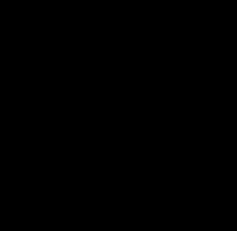

<Figure size 144x144 with 0 Axes>

Using control points [0.50536209 0.58409179 1.15099003]
Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 144x144 with 0 Axes>

Using control points [0.50536209 0.58409179 1.15099003]
Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 144x144 with 0 Axes>

Using control points [0.50536209 0.58409179 1.15099003]
Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 144x144 with 0 Axes>

Using control points [0.50536209 0.58409179 1.15099003]
Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


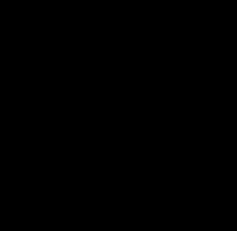

<Figure size 144x144 with 0 Axes>

Using control points [0.50536209 0.58409179 1.15099003]
Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 144x144 with 0 Axes>

Using control points [0.50536209 0.58409179 1.15099003]
Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 144x144 with 0 Axes>

Using control points [0.50536209 0.58409179 1.15099003]
Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 144x144 with 0 Axes>

Using control points [0.50536209 0.58409179 1.15099003]
Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


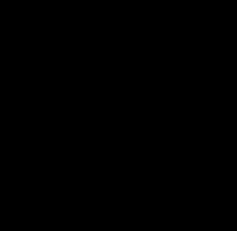

<Figure size 144x144 with 0 Axes>

Using control points [0.50536209 0.58409179 1.15099003]
Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 144x144 with 0 Axes>

Using control points [0.50536209 0.58409179 1.15099003]
Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 144x144 with 0 Axes>

Using control points [0.50536209 0.58409179 1.15099003]
Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


<Figure size 144x144 with 0 Axes>

Using control points [0.50536209 0.58409179 1.15099003]
Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


In [16]:
from IPython.display import HTML
HTML(test_matplot_animate_multi.to_jshtml())

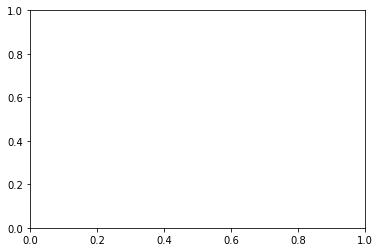

In [22]:
test_matplot_animate_single = animate_matplot_brain(
    user_epoch,
    stc = stc,
    hemi = 'lh',
    views = 'lat',
    colorbar = True,
    colormap_limit_type = 'lims',
    cmax = 3,
)

Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


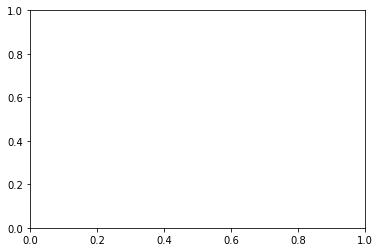

Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


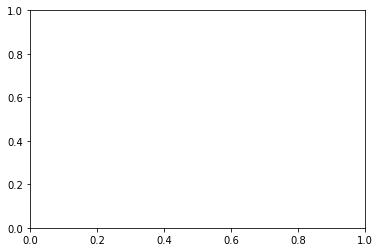

Octahedron subdivision grade 5
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    2 smooth iterations done.


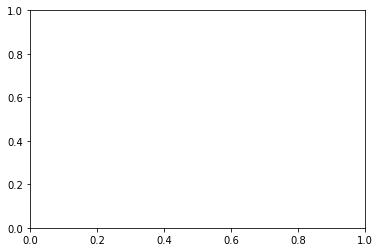

CPU times: user 3.63 s, sys: 707 ms, total: 4.34 s
Wall time: 3.27 s


In [23]:
%%time
from IPython.display import HTML
HTML(test_matplot_animate_single.to_jshtml())

-------

# TESTING ENVIRONMENT

In [23]:
import matplotlib.gridspec as gridspec

def move_axes(ax, fig, subplot_spec=111):
    """Move an Axes object from a figure to a new pyplot managed Figure in
    the specified subplot."""

    # get a reference to the old figure context so we can release it
    old_fig = ax.figure

    # remove the Axes from it's original Figure context
    ax.remove()

    # set the pointer from the Axes to the new figure
    ax.figure = fig

    # add the Axes to the registry of axes for the figure
    fig.axes.append(ax)
    # twice, I don't know why...
    fig.add_axes(ax)

Using control points [0.50214107 0.5804117  1.14456482]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


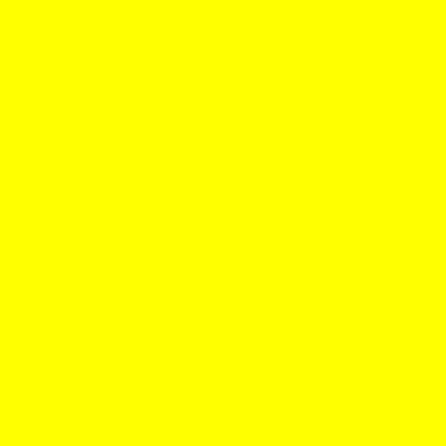

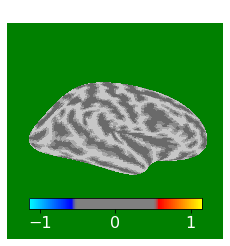

Using control points [0.50214107 0.5804117  1.14456482]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


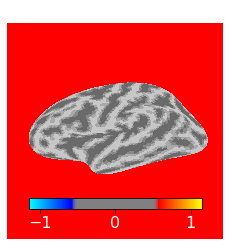

Using control points [0.50214107 0.5804117  1.14456482]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


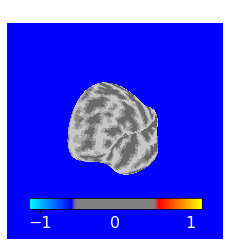

Using control points [0.50214107 0.5804117  1.14456482]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


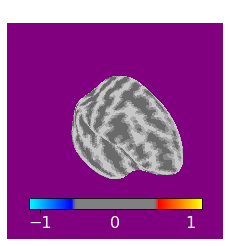

Using control points [0.50214107 0.5804117  1.14456482]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


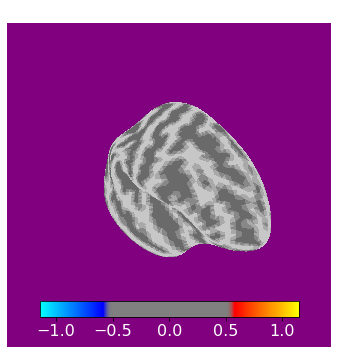

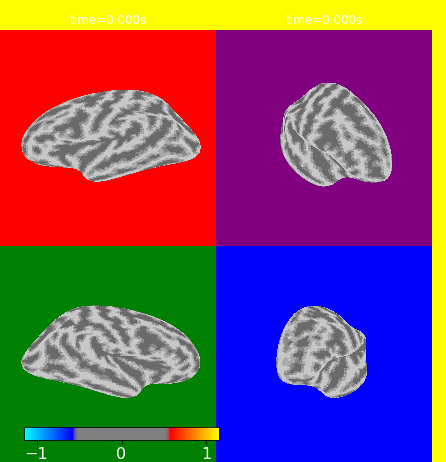

In [190]:
#base_fig = plt.figure(figsize = (6,6))
#plt.subplot(111)

base_fig = plt.figure(figsize = (6,6), facecolor="yellow")

left = 0
bottom = 0
width = 1
height = 1
ax = base_fig.add_axes([left, bottom, width, height])
plt.axis('off')

fig = plt.figure(figsize = (3,3))
stc.plot(backend = 'matplotlib',
                         initial_time = 0,
                         hemi = 'rh',
                         size = [100, 100],
                         background = 'green',
                         alpha = 0.5,
                         figure = fig
                        );
#base_fig.axes[1].remove()

# Copy over brain image
move_axes(fig.axes[0], base_fig)



fig = plt.figure(figsize = (3,3))
stc.plot(backend = 'matplotlib',
                         initial_time = 0,
                         hemi = 'lh',
                         size = [100, 100],
                         background = 'red',
                         alpha = 0.5,
                         figure = fig
                        );

move_axes(fig.axes[0], base_fig)
pos1 = base_fig.axes[1].get_position() 
pos2 = [pos1.x0 + 0, pos1.y0 + 1.0,  pos1.width, pos1.height] 
base_fig.axes[2].set_position(pos2)





fig = plt.figure(figsize = (3,3))
stc.plot(backend = 'matplotlib',
                         initial_time = 0,
                         views = 'fro',
                         hemi = 'lh',
                         size = [100, 100],
                         background = 'blue',
                         alpha = 0.5,
                         figure = fig
                        );

move_axes(fig.axes[0], base_fig, subplot_spec = 111)
pos2 = [pos1.x0 + 1.0, pos1.y0 + 0,  pos1.width, pos1.height] 
base_fig.axes[3].set_position(pos2)




fig = plt.figure(figsize = (3,3))
stc.plot(backend = 'matplotlib',
                         initial_time = 0,
                         views = 'fro',
                         hemi = 'rh',
                         size = [100, 100],
                         background = 'purple',
                         alpha = 0.5,
                         figure = fig
                        );

move_axes(fig.axes[0], base_fig, subplot_spec = 111)
pos2 = [pos1.x0 + 1.0, pos1.y0 + 1,  pos1.width, pos1.height] 
base_fig.axes[4].set_position(pos2)



fig = plt.figure(figsize = (4.5, 4.5))
stc.plot(backend = 'matplotlib',
                         initial_time = 0,
                         views = 'fro',
                         hemi = 'rh',
                         size = [100, 100],
                         background = 'purple',
                         alpha = 0.5,
                         figure = fig
                        );

# Copy over only colorbar
move_axes(fig.axes[1], base_fig)

base_fig

In [171]:
base_fig.axes[5].set_xticklabels

[<Axes:>,
 <Axes3D:title={'center':'time=0.000s'}>,
 <Axes3D:title={'center':'time=0.000s'}>,
 <Axes3D:title={'center':'time=0.000s'}>,
 <Axes3D:title={'center':'time=0.000s'}>,
 <AxesHostAxes:>]

In [179]:
base_fig.

TypeError: 'FigureCanvasAgg' object is not callable

In [ ]:
fig1.axes

In [ ]:
pos2

In [ ]:
Bbox.from_extents(0, 0, 1, 1)

In [ ]:
import matplotlib as mpl

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

brain = stc.plot(views='fro',
                    hemi='lh',
                    background='red',  
                    #foreground='black', 
                    backend = 'matplotlib',
                    #time_viewer = True,
                    #view_layout=view_layout,  
                    #brain_kwargs = dict(foreground = "black"),
                    #add_data_kwargs=dict(time_label_size=time_label_size,
                                      #colorbar_kwargs=dict(label_font_size=colorbar_font_size)),
                );

In [ ]:
# CODE GRAVEYARD


# FOR PLOTTING THE FIGURE OF THE MULTI-VIEW MATPLOTLIB DIRECTLY

#     else:
        
#         def animate(frame):
#             #brain.clear()
#             #fig.clear()

#             brain = plotting(
#                 #figure = fig,
#                 display_time = frame);
#             return [brain.figure]

#         ani = animation.FuncAnimation(
#             brain,
#             animate,
#             frames=times_to_show,
#             interval=ms_between_frames,  # Time between frames in ms
#             blit=False
#         )





# FOR PLOTTING BY ADDING AN AXIS TO EXPAND THE FIGURE SIZE INSTEAD OF MAKNIG A BIG ONE TO BEGIN WITH

#    if backend != 'matplotlib':
#         return (make_plot())
    
#     elif (hemi == 'lh' and len(views) == 1) or (hemi == 'rh' and len(views) == 1):
#         return (make_plot(views = views[0]))
    
#     else:
        
#         from matplotlib.transforms import Bbox
        
#         if hemi == 'both' or hemi == 'split':
#             brain_hemi = ['lh', 'rh']

#         else:
#             brain_hemi = [hemi]

# #         if figure:
# #             base_fig = figure 
# #         else:
            
#         base_fig = plt.figure(figsize=(figsize, figsize), facecolor="black")
            
            
#         #plt.show(block=True)
#         #plt.close()

#         width = len(views)
#         height = len(brain_hemi)
#         ax = base_fig.add_axes([0, 0, width, height]) # left, bottom, width, height
#         plt.axis('off')

#         x_pos = 0
#         axes_pos = 1
        
#         # Run to add new fig for each view
#         for v in range(len(views)):
            
#             y_pos = 0
            
#             # run twice for each side of the brain if using both or split
#             for h in range(len(brain_hemi)):                
                
#                 plt.show(block=True)
#                 fig = plt.figure(figsize = (figsize,figsize))
#                 make_plot(figure = fig, hemi = brain_hemi[h], views = str(views[v]), colorbar = colorbar)
                
#                 # For first view of first hemi move axis in pos 0 twice to get colorbar 
#                 if h == 0 and v == 0:
#                     colorbar = False
#                     move_axes(fig.axes[0], base_fig)
                    
                
#                 # Copy over colorbar in 1st loop or brain in any subsequent loop
#                 move_axes(fig.axes[0], base_fig)
                
                
#                 pos1 = base_fig.axes[1].get_position() 
#                 pos2 = [pos1.x0 + x_pos, pos1.y0 + y_pos,  pos1.width, pos1.height] 
#                 base_fig.axes[axes_pos].set_position(pos2) #1, 3, 4, 5
            
                
#                 if h == 0 and v == 0:
#                     axes_pos += 2
#                 else:
#                     axes_pos += 1
                    
#                 y_pos = 1
            
#             x_pos += 1
            

#     return(base_fig)







# VERSION OF PLOTTING FUNCTION THAT SAVES EACH VIEW AS AN IMAGE


#     def make_plot(
#          epoch = epochs,
#          stc = stc,
#          views=views,
#          hemi=hemi,
#          colormap=colormap,
#          surface = surface,
#          size=auto_plot_size,
#          subject=None,
#          initial_time=display_time,
#          clim=clim_values,
#          time_viewer=False,  # Use to open up interactive version
#          show_traces=False,
#          colorbar=colorbar,
#          transparent=transparent,
#          alpha=alpha, 
#          figure = figure,
#          cortex=cortex, 
#          background=background, 
#          foreground=foreground, 
#          spacing=spacing,
#          backend = backend,
#          view_layout=view_layout,
#          smoothing_steps=smoothing_steps,
#          time_label_size=time_label_size,
#          label_font_size=colorbar_font_size,
#          ):
#             #plt.ioff()
#             #import matplotlib as mpl
#             #mpl.use('Agg')
#             plt.show(block=True)
            
#             brain = stc.plot(
#                     views=views,
#                     surface=surface,
#                     hemi=hemi,
#                     colormap=colormap,
#                     size=size,
#                     subject=None,
#                     initial_time=initial_time,
#                     clim=clim_values,
#                     time_viewer=False, 
#                     show_traces=False,
#                     colorbar=colorbar,
#                     transparent=transparent,
#                     alpha=alpha, 
#                     figure = figure,
#                     cortex=cortex,
#                     background=background,  
#                     foreground=foreground, 
#                     spacing=spacing,
#                     backend = backend,
#                     view_layout=view_layout,  
#                     smoothing_steps=smoothing_steps,
#                     brain_kwargs = dict(show = False),
#                     add_data_kwargs=dict(time_label_size=time_label_size,
#                                       colorbar_kwargs=dict(label_font_size=colorbar_font_size)),
#                 );
#             #plt.close()
#             return brain
            
            
            
#     if backend != 'matplotlib':
#         return (make_plot())
    
#     elif (hemi == 'lh' and len(views) == 1) or (hemi == 'rh' and len(views) == 1):
#         return (make_plot(views = views[0]))
    
#     else:
#         view_images = []
            
#         for v in range(len(views)):

#             brain_images = list()
            
#             if hemi == 'both' or hemi == 'split':
#                 brain_hemi = ['lh', 'rh']
#                 final_axis = 0 # Will stack images of both hemis vertically
#             else:
#                 brain_hemi = [hemi]
#                 final_axis = 1 # Will lay out each each specified view horizontally

#             # run twice for each side of the brain if using both or split
#             for i in range(len(brain_hemi)):

#                 #fig, ax = plt.subplots(figsize=(3, 3))
#                 fig = plt.figure(figsize=(figsize, figsize))

#                 make_plot(figure = fig, hemi = brain_hemi[i], views = str(views[v]), size = [100,100], colorbar = colorbar)
                
#                 # Remove colorbar if not in the top left
#                 if i == 0 and v == 0:
#                     colorbar = False
#                 else:
#                     # Manually remove colorbar
#                     fig.axes[1].remove() 
#                     # CURRENLY AXIS 2 IS REMOVED BECAUSE I'M USING SUBPLOTS, REMOVE 1 WITHOUT THEM.

#                 # Convert figures to images so they can be combined
#                 #ax.margins(0)
#                 plt.show(block=True)
#                 fig.canvas.draw()
#                 plot_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
#                 plot_image = plot_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

#                 brain_images.append(plot_image)
            
#             if hemi == 'both' or hemi == 'split':
#                 view_image = np.concatenate((brain_images[0], brain_images[1]), axis=1)
#             else:
#                 view_image = brain_images[0]
            
#             view_images.append(view_image)

#     if len(view_images) > 1:
#         for i in range(1, len(view_images)):
#             view_images[0] = np.concatenate((view_images[0], view_images[i]), axis=final_axis)

#     return (view_images[0])



# GENERATE OWN COLORBAR
            
#             from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
#             ax_divider = make_axes_locatable(ax)
#             clim = dict(kind='value', lims=[cmin, cmid, cmax])
#             cax = ax_divider.append_axes("right", size="100%", pad="0%")
#             # https://mne.tools/stable/generated/mne.viz.plot_brain_colorbar.html
#             mne.viz.plot_brain_colorbar(
#                 cax,
#                 clim,
#                 colormap=colormap,
#                 transparent=False,
#                 orientation='vertical',
#                 label='µV',
#                 bgcolor='w',
#             )